In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/06_00_062.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/08_00_082.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/F9-52.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/02_00_242.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/05_00_183.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/05_00_013.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/02_00_183.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/F9-22.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/F10-43.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/F66-12.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/06_00_193.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/10_00_063.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/F5-2.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/06_00_133.p

In [4]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
import os
import numpy as np 
import pandas as pd 

import imageio.v2 as imageio

import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from scipy.io import loadmat

In [5]:
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers.core import Activation, Reshape
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization

In [ ]:
import tensorflow_addons as tfa

Text(0.5, 1.0, 'Segmentation')

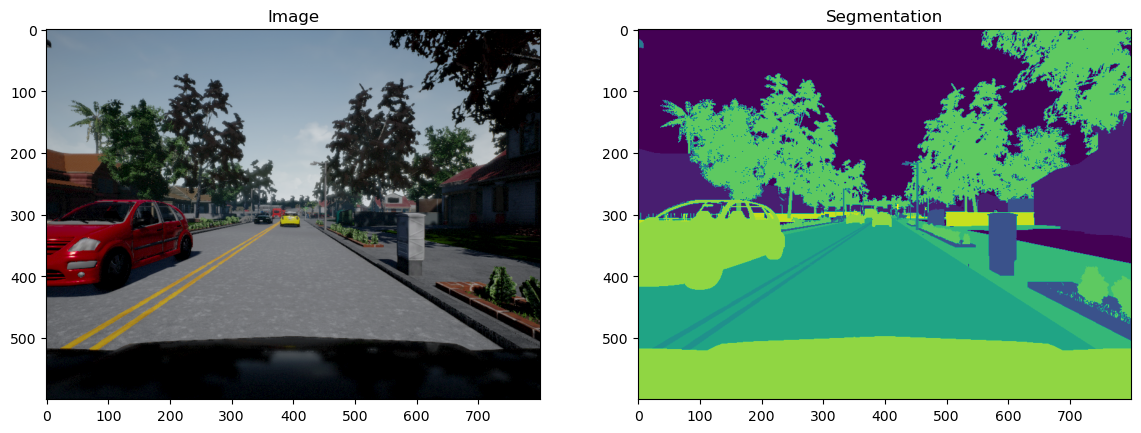

In [124]:
image_path = ('/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraRGB/')
mask_path = ('/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraSeg/')
test_path = ('/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraRGB/')
test_mask = ('/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/')
image_list = sorted(os.listdir(image_path))
mask_list = sorted(os.listdir(mask_path))
test_image_list = sorted(os.listdir(test_path))
test_mask_list = sorted(os.listdir(test_mask))
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]
test_image_list = [test_path+i for i in test_image_list]
test_mask_list = [test_mask+i for i in test_mask_list]
img = imageio.imread(image_list[120])
mask = imageio.imread(mask_list[120])
    

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:,:,0])
arr[1].set_title('Segmentation')

In [126]:
len(test_mask_list)

1000

In [127]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)
test_image_list_ds = tf.data.Dataset.list_files(test_image_list, shuffle=False)
test_mask_list_ds = tf.data.Dataset.list_files(test_mask_list, shuffle=False)


image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)
test_image_filenames = tf.constant(test_image_list)
test_masks_filenames = tf.constant(test_mask_list)
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_filenames, test_masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_000.png', shape=(), dtype=string)
tf.Tensor(b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraSeg/02_00_000.png', shape=(), dtype=string)


In [128]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32) #/255

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True) #/255
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (256, 256), method='nearest')
    input_mask = tf.image.resize(mask, (256, 256), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
test_image_ds = test_dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)
test_processed_image_ds = test_image_ds.map(preprocess)

In [129]:
from keras.layers import add
from keras.layers import ReLU
from keras.layers import Layer
from keras.layers import multiply
from keras.layers import MaxPool2D
from keras.layers import UpSampling2D
from keras.layers import BatchNormalization

In [130]:
class AttentionGate(Layer):

    def __init__(self, filters, rate, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)
        
        self.filters = filters
        self.rate = rate
        self.act = ReLU()

        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu')
        self.resample = UpSampling2D()
        self.c = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')        
        
    def call(self, X):
        x, skip_x = X
        
        x = self.normal(x)  
        skip = self.down(skip_x)  
        
        x = add([x, skip])  
        x = self.act(x)
        x = self.c(x)      
        x = self.resample(x)  
         
        skip_x = multiply([x, skip_x])  
        return skip_x
        
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "rate":self.rate,
        }

In [131]:

def AtrousSpatialPyramidPooling(model_input):
  dims = tf.keras.backend.int_shape(model_input)

  layer = tf.keras.layers.AveragePooling2D(pool_size=(dims[-3],
                                                      dims[-2]))(model_input)
  layer = tf.keras.layers.Conv2D(64, kernel_size=1, padding='same',
                                 kernel_initializer = 'he_normal')(layer)
  layer = tf.keras.layers.BatchNormalization()(layer)
  layer = tf.keras.layers.ReLU()(layer)
  out_pool = tf.keras.layers.UpSampling2D(size = (dims[-3] // layer.shape[1],
                                               dims[-2] // layer.shape[2]),
                                        interpolation = 'bilinear')(layer)

  layer = tf.keras.layers.Conv2D(64, kernel_size = 1,
                                   dilation_rate = 1, 
                                   padding = 'same',
                                   kernel_initializer = 'he_normal',
                                   use_bias = False)(model_input)
  layer = tf.keras.layers.BatchNormalization()(layer)
  out_1 = tf.keras.layers.ReLU()(layer)


  layer = tf.keras.layers.Conv2D(64, kernel_size = 3,
                                   dilation_rate = 6, 
                                   padding = 'same',
                                   kernel_initializer = 'he_normal',
                                   use_bias = False)(model_input)
  layer = tf.keras.layers.BatchNormalization()(layer)
  out_6 = tf.keras.layers.ReLU()(layer)


  layer = tf.keras.layers.Conv2D(64, kernel_size = 3,
                                   dilation_rate = 12, 
                                   padding = 'same',
                                   kernel_initializer = 'he_normal',
                                   use_bias = False)(model_input)
  layer = tf.keras.layers.BatchNormalization()(layer)
  out_12 = tf.keras.layers.ReLU()(layer)


  layer = tf.keras.layers.Conv2D(64, kernel_size = 3,
                                   dilation_rate = 18, 
                                   padding = 'same',
                                   kernel_initializer = 'he_normal',
                                   use_bias = False)(model_input)
  layer = tf.keras.layers.BatchNormalization()(layer)
  out_18 = tf.keras.layers.ReLU()(layer)

  layer = tf.keras.layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])



  layer = tf.keras.layers.Conv2D(64, kernel_size = 1,
                                   dilation_rate = 1, 
                                   padding = 'same',
                                   kernel_initializer = 'he_normal',
                                   use_bias = False)(layer)
  layer = tf.keras.layers.BatchNormalization()(layer)
  model_output = tf.keras.layers.ReLU()(layer)
      
  


  return model_output

UNET model  input 256x256 classes 23

In [132]:
def double_conv_block(x, n_filters):

    
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

    return x

In [133]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)

    return f, p

In [134]:
def upsample_block(x, conv_features, n_filters):
    
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x) # upsample
     
    x = layers.concatenate([x, conv_features]) # concatenate
    
    x = layers.Dropout(0.3)(x)
   
    x = double_conv_block(x, n_filters)

    return x

In [135]:
def first_unet_model():

    
    inputs = layers.Input(shape=(256,256,3))

    # encoder
    
    f1, p1 = downsample_block(inputs, 64)
    
    f2, p2 = downsample_block(p1, 128)
    
    f3, p3 = downsample_block(p2, 256)
    
    f4, p4 = downsample_block(p3, 512)

    # bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder
    
    u6 = upsample_block(bottleneck, f4, 512)
    
    
    a9 = AtrousSpatialPyramidPooling(f1)
    a_7 = layers.Conv2D(64, 1,strides=(4,4),padding = "same", activation = "relu", kernel_initializer = "he_normal")(a9)
    f_3 = layers.concatenate([a_7,f3 ])
    u7 = upsample_block(u6, f_3, 256)
    
    
    
    
    a_8 = layers.Conv2D(64, 1,strides=(2,2),padding = "same", activation = "relu", kernel_initializer = "he_normal")(a9)
    f_2 = layers.concatenate([a_8,f2 ])
    u8 = upsample_block(u7, f_2, 128)
    
    
    
    
    #a9 = AtrousSpatialPyramidPooling(f1)
    #a4 = AttentionGate(64,0.1,name="Attention4")([u8, a9])
    u9 = upsample_block(u8, a9, 64)

    # output
    outputs = layers.Conv2D(23, 1, padding="same", activation = "softmax")(u9)

    
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [136]:
unet_model = first_unet_model()

In [137]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_282 (Conv2D)            (None, 256, 256, 64  1792        ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_283 (Conv2D)            (None, 256, 256, 64  36928       ['conv2d_282[0][0]']             
                                )                                                             

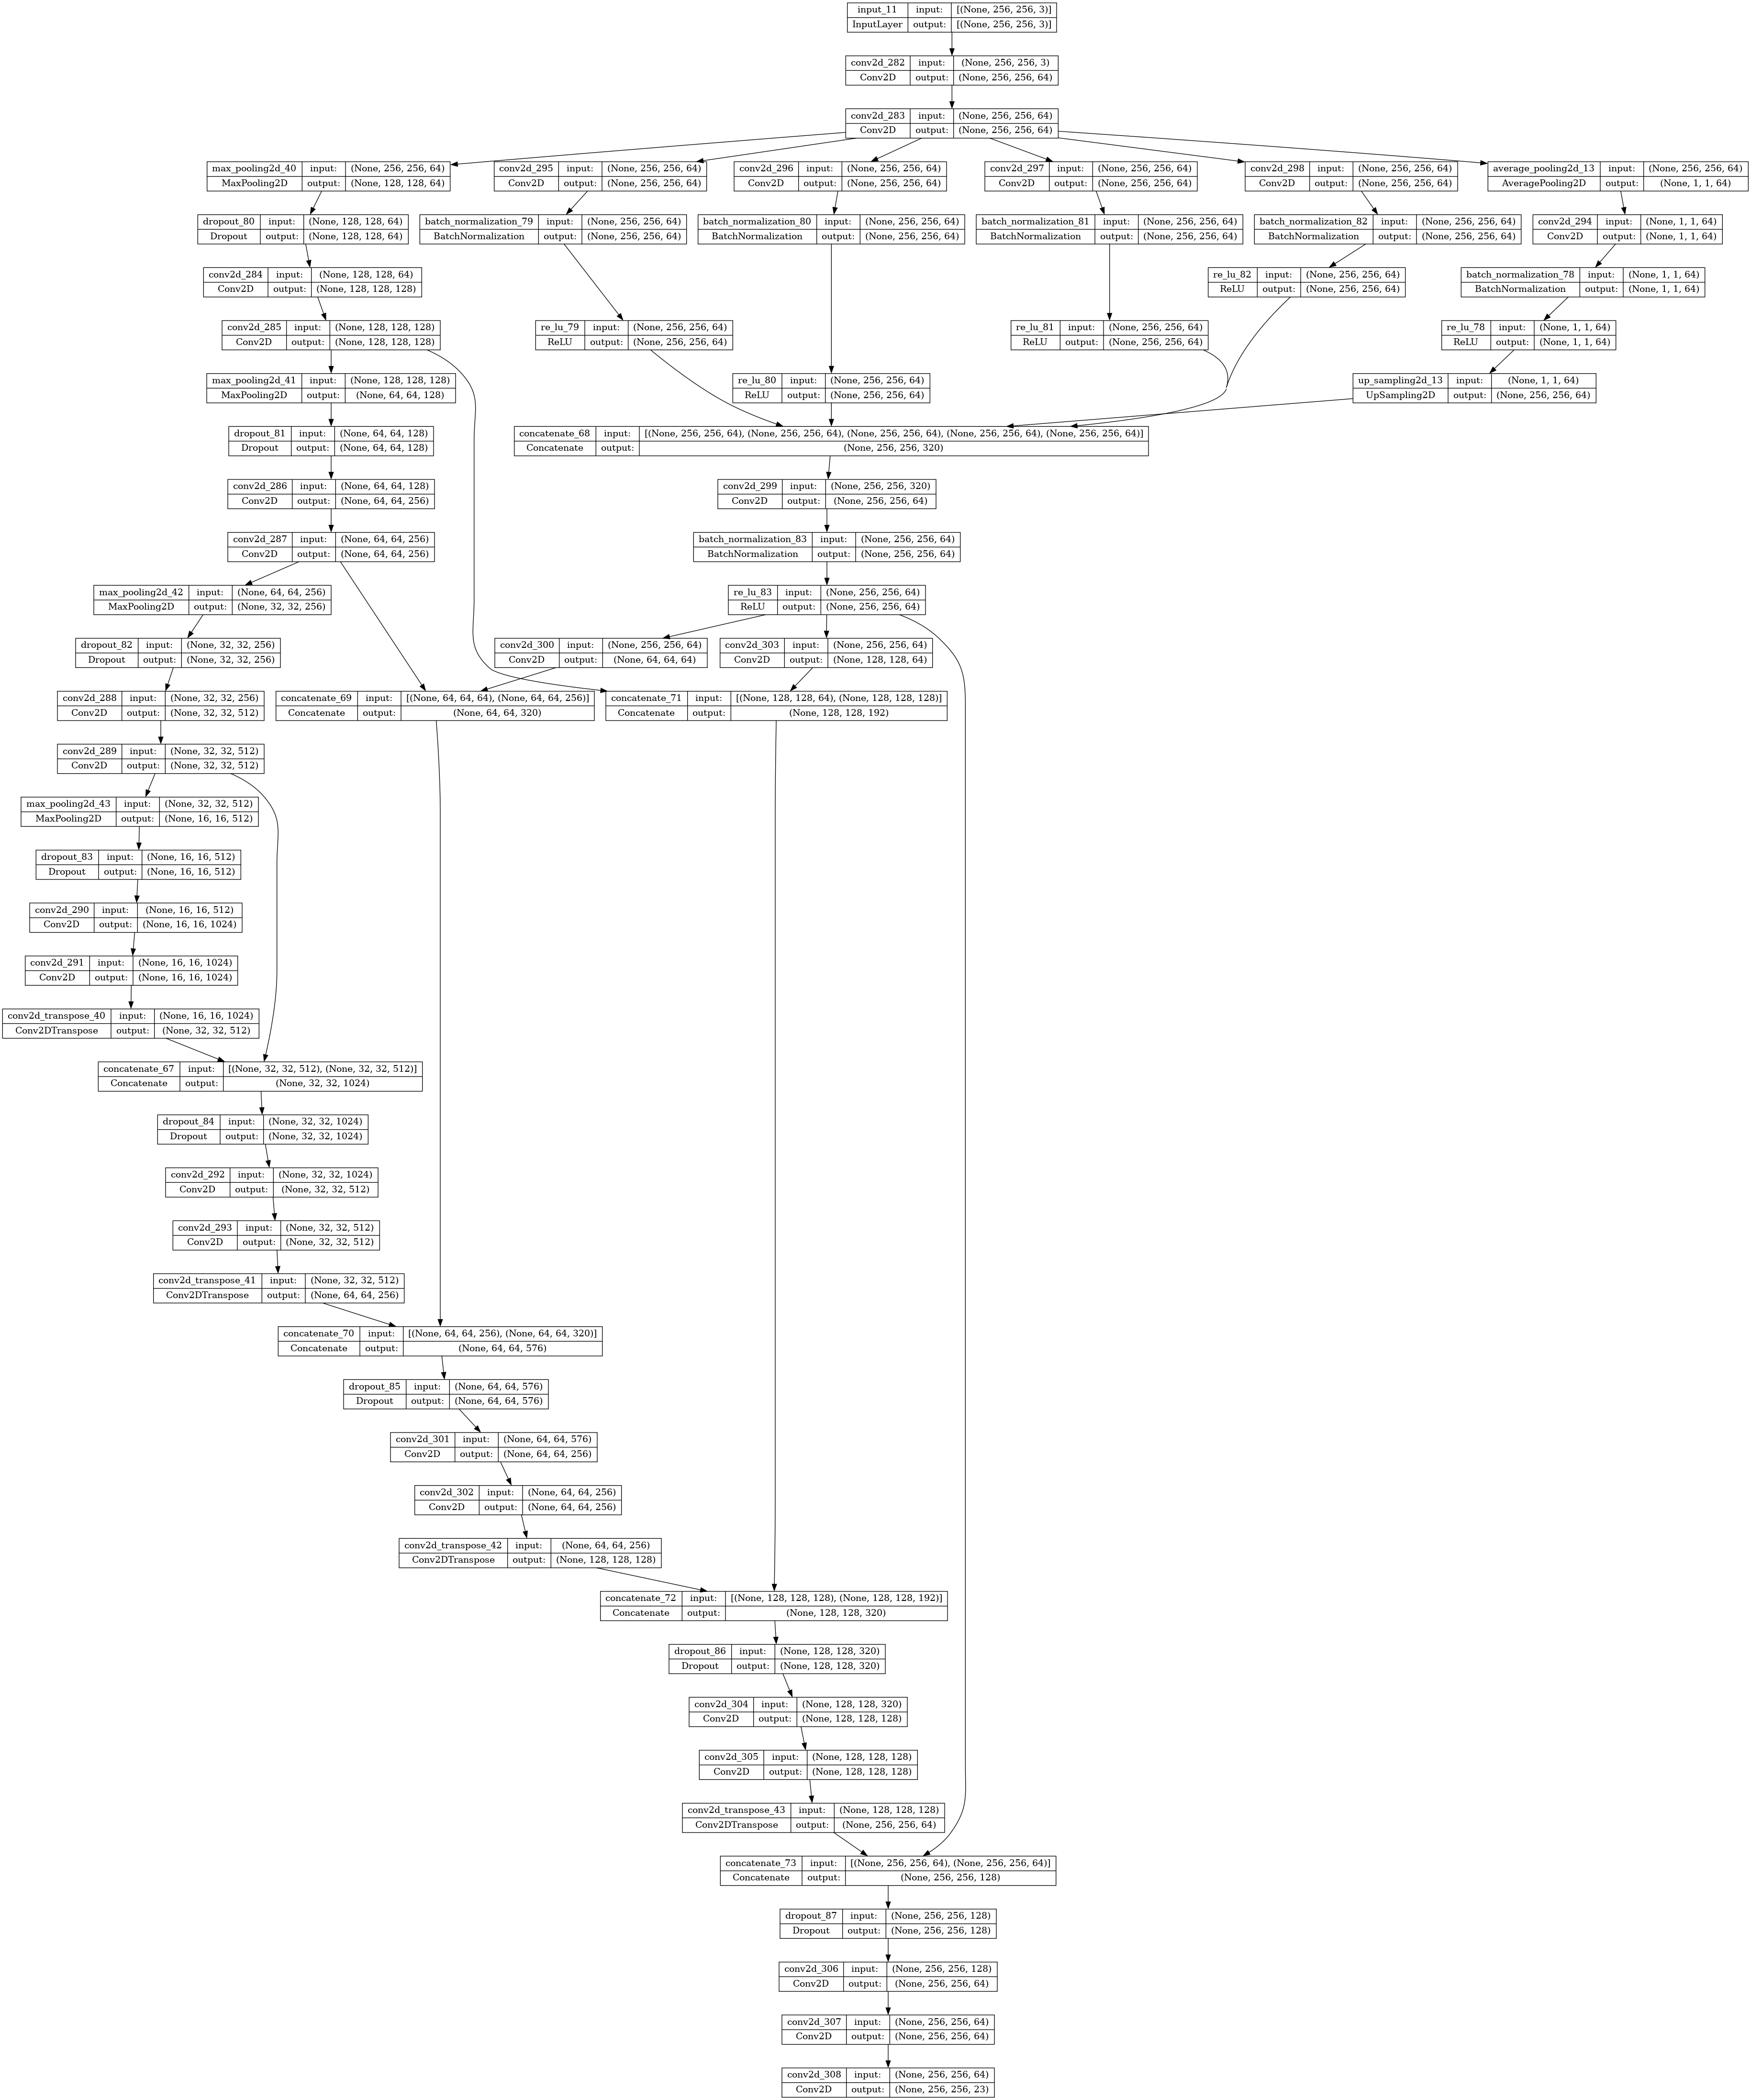

In [138]:
tf.keras.utils.plot_model(unet_model, show_shapes=True)

In [139]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
  def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
    super(UpdatedMeanIoU, self).__init__(num_classes = 23,name=name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)

In [140]:
#!pip install focal-loss
from focal_loss import SparseCategoricalFocalLoss

In [141]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss=SparseCategoricalFocalLoss(gamma=2),
              metrics=[UpdatedMeanIoU(),'accuracy'])

In [142]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

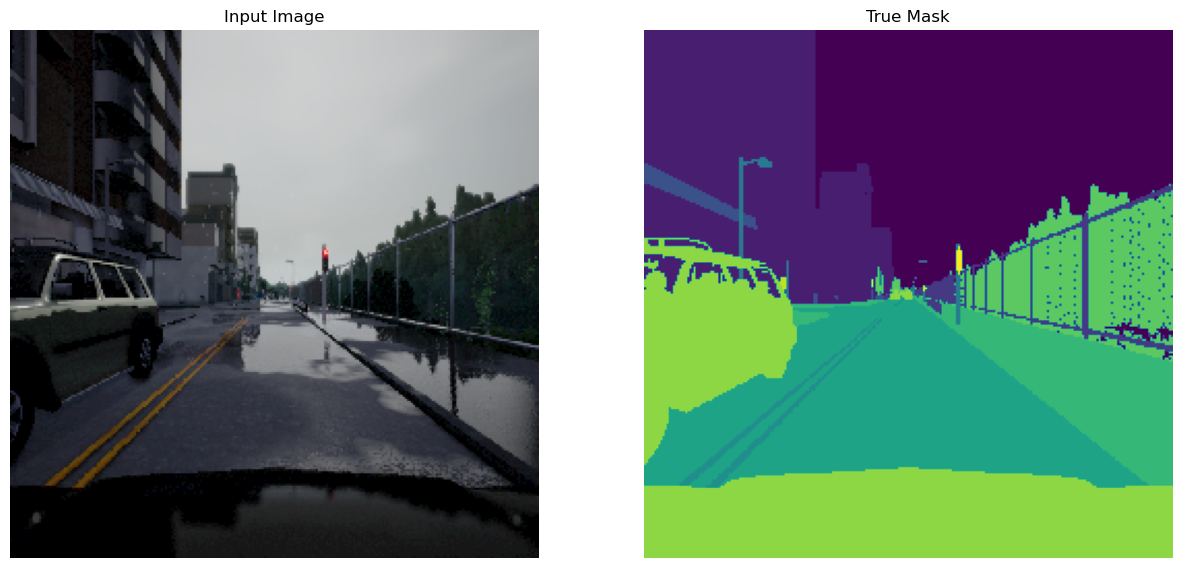

In [143]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [144]:
EPOCHS = 50
VAL_SUBSPLITS = 10
BUFFER_SIZE = 500
BATCH_SIZE = 16
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
tests_dataset = test_processed_image_ds.cache().batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet_model.fit(train_dataset,validation_data=tests_dataset, epochs=EPOCHS)

(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))
Epoch 1/50


2023-05-08 14:56:52.161575: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-Net/dropout_80/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/63 [==============================] - 117s 1s/step - loss: 0.8319 - updated_mean_io_u_5: 0.1130 - accuracy: 0.6508 - val_loss: 1.1167 - val_updated_mean_io_u_5: 0.1966 - val_accuracy: 0.6501
Epoch 2/50
63/63 [==============================] - 75s 1s/step - loss: 0.3956 - updated_mean_io_u_5: 0.3162 - accuracy: 0.7946 - val_loss: 0.6473 - val_updated_mean_io_u_5: 0.2496 - val_accuracy: 0.6996
Epoch 3/50
63/63 [==============================] - 75s 1s/step - loss: 0.3050 - updated_mean_io_u_5: 0.3710 - accuracy: 0.8386 - val_loss: 0.8146 - val_updated_mean_io_u_5: 0.2483 - val_accuracy: 0.6531
Epoch 4/50
63/63 [==============================] - 75s 1s/step - loss: 0.2517 - updated_mean_io_u_5: 0.4039 - accuracy: 0.8677 - val_loss: 0.5730 - val_updated_mean_io_u_5: 0.3079 - val_accuracy: 0.7222
Epoch 5/50
63/63 [==============================] - 75s 1s/step - loss: 0.2159 - updated_mean_io_u_5: 0.4297 - accuracy: 0.8857 - val_loss: 0.6305 - val_updated_mean_io_u_5: 0.3185 - val_accurac

In [145]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet_model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 409ms/step


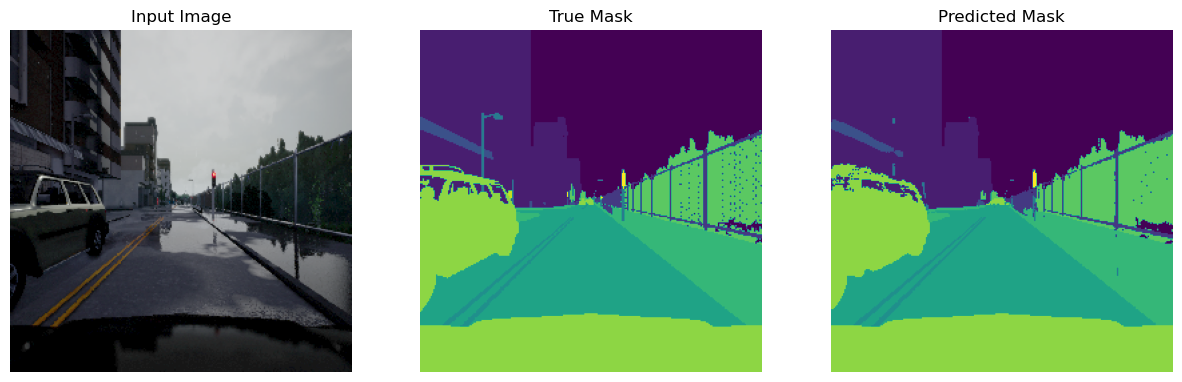

1/1 [==============================] - 0s 34ms/step


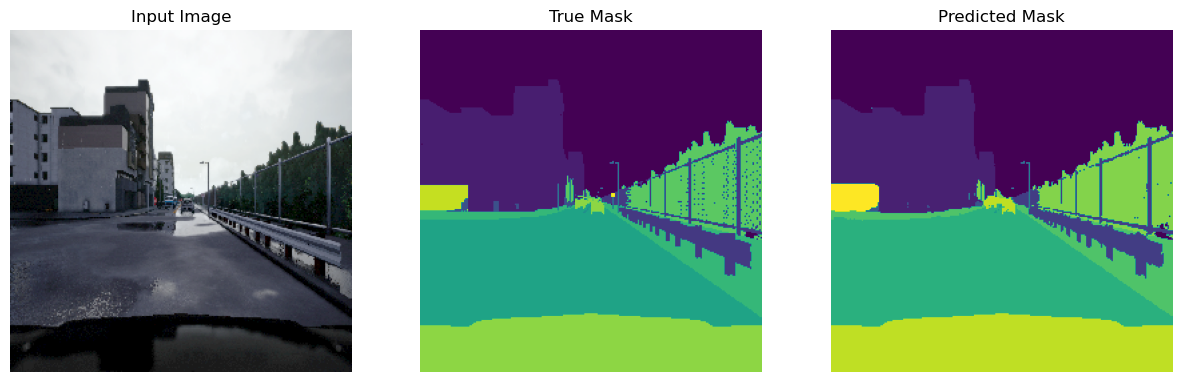

1/1 [==============================] - 0s 29ms/step


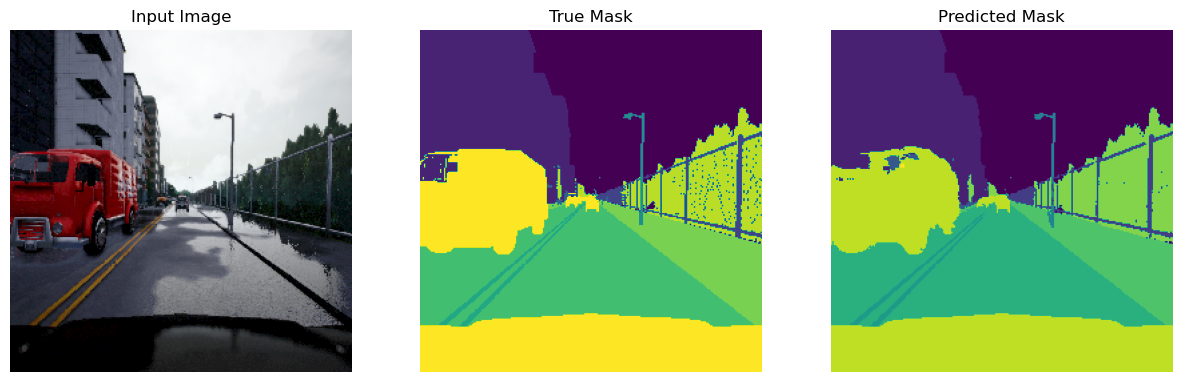

1/1 [==============================] - 0s 29ms/step


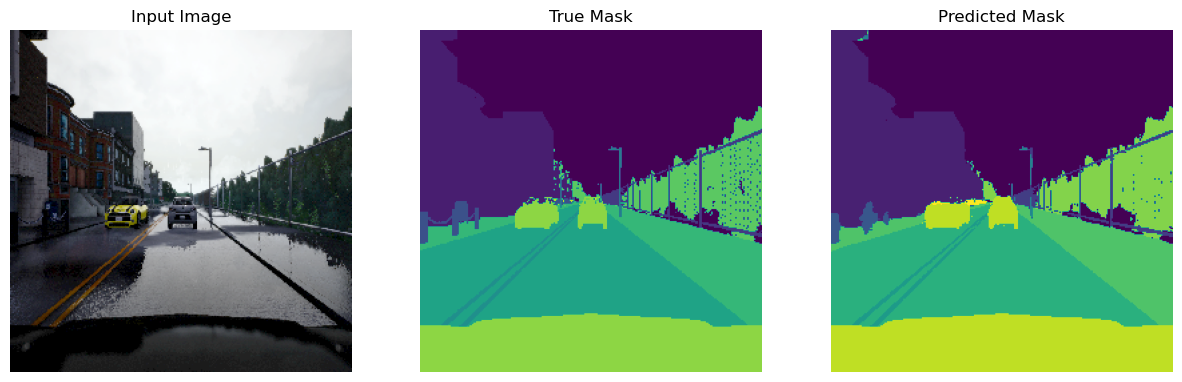

1/1 [==============================] - 0s 34ms/step


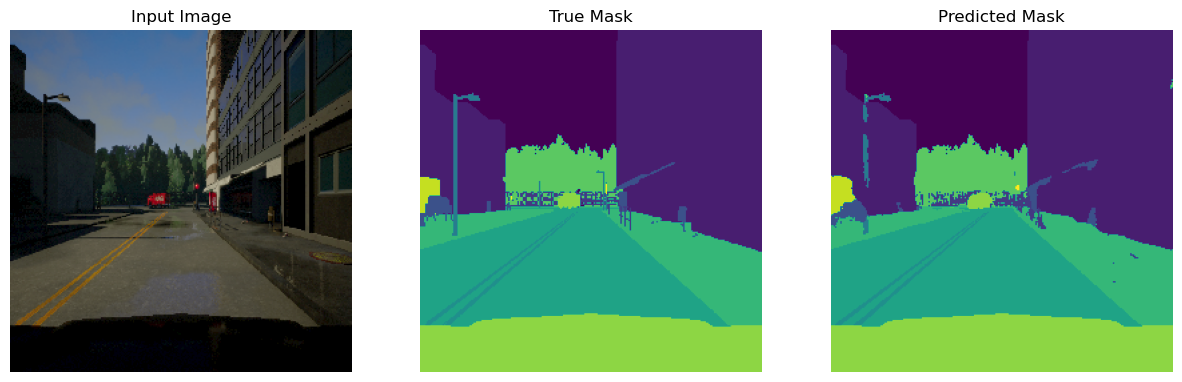

In [146]:
show_predictions(tests_dataset, 5)